### Boilerplate

In [11]:
import tqdm, numpy as np
import matplotlib.pyplot as plt
import utils
import umap
import hdbscan
import matplotlib.pyplot as plt
import logging
from bson.objectid import ObjectId
import gc
import tasks
from sklearn.preprocessing import StandardScaler
import numba
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, cosine_distances
import umap.plot
from sklearn.cluster import KMeans

# for jupyter notebook widgets
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from ipywidgets import interact, interactive

In [61]:
# connect to database
db = utils.connect()
db

Database(MongoClient(host=['20.220.215.35:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', authmechanism='SCRAM-SHA-256', connecttimeoutms=50000, serverselectiontimeoutms=50000, directconnection=True, replicaset='rs0'), 'aita')

### Setup Human Clusters

In [62]:
# hardcoded group id strings
group_id_strings = ['63901a89e189962b660959cf', '63901a92931eeac91c9924a1', '63901a96e189962b660959d3']

# convert to objectId's
group_ids = [ObjectId(str(id)) for id in group_id_strings]

# retrieve groups from database
groups = list(db.groups.find({"_id":{"$in" : group_ids}}))
print("Retrieved " + str(len(groups)) + " groups from database")

ServerSelectionTimeoutError: client is configured to connect to a replica set named 'rs0' but this node belongs to a set named 'None', Timeout: 50.0s, Topology Description: <TopologyDescription id: 63f6a59188f0a6b1bdb2f90a, topology_type: Single, servers: [<ServerDescription ('20.220.215.35', 27017) server_type: Unknown, rtt: None, error=ConfigurationError("client is configured to connect to a replica set named 'rs0' but this node belongs to a set named 'None'")>]>

In [14]:
groups[0]['history'][0]['included_documents']

['hetv62', 'lwd55z', 'dhbdpv', 'eyj0sv']

In [15]:
# projection here to only include the fields we want
projection = {'id': 1, 'textVector': 1}
projection

{'id': 1, 'textVector': 1}

### Create Training Set

Options to define training set:
1. Use the first groups teleoscope ordering
2. Use all documents
3. Create a new teleo vec from all documents in human clusters

Embeddings
- save training set upon creation (check if created or not)
    - we need to save both ids and vectors for recall at the end

#### Save & Create Training Data

##### Using First Group's Teleoscope Ordering

Change Raw cells below to Code if you need to reload document ids / vectors

##### Using All Docs

In [ ]:
def cacheClusteringData(db):
    """
    Check to see if distance matrix and list of document ids is cached in ~/embeddings
    
    input:
        db: mongoDB connection
    output:
        dm: distance matrix
        ids: list of document ids
    """
    from pathlib import Path
    npzpath = Path('/clustering.npz').expanduser()
    
    if npzpath.exists():
        print("Documents have been cached, retrieving now.")
        loaded = np.load(npzpath.as_posix(), allow_pickle=False)
        dm = loaded['dist_matrix']
        ids = loaded['doc_ids'].tolist()
    
    else:
        print("Documents are not cached, building cache now.")
        # db = utils.connect()
        allDocuments = utils.getAllDocuments(db, projection={'id':1, 'textVector':1, '_id':0}, batching=True, batchSize=10000)
        ids = [x['id'] for x in allDocuments]
        print(f'There are {len(ids)} ids in documents.')

        vecs = np.array([x['textVector'] for x in allDocuments])
        dm = euclidean_distances(vecs)
        print(f'The distance matrix has shape: {dm.shape}')

        np.savez(npzpath.as_posix(), dist_matrix=dm, doc_ids=ids)
    
    return dm, ids

#### Load Training Data

##### Using First Group's Teleoscope Ordering

In [ ]:
# loaded = np.load('all_order_docs.npz')
loaded = np.load('teleo_order_docs.npz')
document_ids = loaded['doc_ids'].tolist()
document_vectors = loaded['doc_vecs']
len(document_ids)

##### Using First Group's Teleoscope Ordering

In [ ]:
# loaded = np.load('all_order_docs.npz')
dm, document_ids = cacheClusteringData(db)

#### Append documents in human clusters

In [17]:
i = 0
group_doc_indices = {}
for group in groups:
    
    # grab latest history item for each group
    group_document_ids = group["history"][0]["included_documents"]
    
    indices = []
    
    for id in group_document_ids:
        
        try:
            document_ids.index(id)
        
        except:
            document = db.documents.find_one({"id": id}, projection=projection)
            document_ids.append(id)
            vector = np.array(document["textVector"]).reshape((1, 512))
            document_vectors = np.append(document_vectors, vector, axis=0)
            
        finally:
            indices.append(document_ids.index(id))
    
    group_doc_indices[group["history"][0]["label"]] = indices
    
    print(f'\nAdding group {i}')
    print("Document ids has the shape: ", len(document_ids))
    print("Document vectors has the shape: ", document_vectors.shape)

            

    i += 1

print(group_doc_indices)


Adding group 0
Document ids has the shape:  10000
Document vectors has the shape:  (10000, 512)

Adding group 1
Document ids has the shape:  10005
Document vectors has the shape:  (10005, 512)

Adding group 2
Document ids has the shape:  10010
Document vectors has the shape:  (10010, 512)
{'wifi': [5630, 7789, 2801, 3965], 'password': [10000, 10001, 10002, 10003, 6135, 9393, 10004], 'security': [10005, 10006, 10007, 10008, 10009]}


### Clustering

#### UMAP

##### Create Distance Matrix

In [18]:
# using sklean euclidean distances
dm = euclidean_distances(document_vectors)
dm.shape

(10010, 10010)

##### Map 0 Distances

In [19]:
group_doc_indices

{'wifi': [5630, 7789, 2801, 3965],
 'password': [10000, 10001, 10002, 10003, 6135, 9393, 10004],
 'security': [10005, 10006, 10007, 10008, 10009]}

In [58]:
for group in group_doc_indices:
    
    indices = group_doc_indices[group]
    size = range(len(indices))

    for _i in size:
        i = indices[_i]

        for _j in size:
            j = indices[_j]
            dm[i, j] = 0 

In [60]:
# sanity check to make sure two docs in the same human cluster are distance 0
i = group_doc_indices['password'][0]
j = group_doc_indices['password'][3]
dm[i,j] == 0

True

##### Reduction

In [28]:
umap_embeddings = umap.UMAP(
    verbose = True,         # for logging
    metric = "precomputed", # use distance matrix
    n_components = 30,      # reduce to n_components dimensions (2:100)
    # n_neighbors = 10,     # local (small n ~2) vs. global (large n ~100) structure 
    min_dist = 0.0,         # minimum distance apart that points are allowed (0.0:0.99)
).fit_transform(dm)

/Users/leofk/opt/anaconda3/envs/mallard/lib/python3.10/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


UMAP(metric='precomputed', min_dist=0.0, n_components=30, verbose=True)
Wed Feb 22 11:31:34 2023 Construct fuzzy simplicial set
Wed Feb 22 11:31:34 2023 Finding Nearest Neighbors
Wed Feb 22 11:31:36 2023 Finished Nearest Neighbor Search
Wed Feb 22 11:31:39 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed Feb 22 11:31:44 2023 Finished embedding


In [29]:
umap_embeddings.shape

(10010, 30)

In [30]:
# compute inter cluster distances for human groups
for group in range(len(groups)):
    
    docs = groups[group]['history'][0]['included_documents']
    print(f'Group {group}')
    dst = []
    
    for i in range(len(docs)):
        
        index_i = document_ids.index(docs[i])
        a = umap_embeddings[index_i]
        
        for j in range(len(docs)):
        
            index_j = document_ids.index(docs[j])
            b = umap_embeddings[index_j]
            euc_a_b = euclidean_distances([a],[b])[0][0]
            dst.append(euc_a_b)
            # print(f'dist({index_i}, {index_j}) = {euc_a_b}')
    
    mean = sum(dst) / len(dst)
    print(f'AVG Dist = {mean}\n')

Group 0
AVG Dist = 0.1223433162085712

Group 1
AVG Dist = 0.018289290618582175

Group 2
AVG Dist = 0.03837434157729149



#### HDBSCAN

In [31]:
hdbscan_labels = hdbscan.HDBSCAN(
    min_cluster_size = 10,              # n-neighbors needed to be considered a cluster (0:50 df=5)
    # min_samples = 5,                  # how conservative clustering will be, larger is more conservative (more outliers) (df=None)
    cluster_selection_epsilon = 0.2,    # have large clusters in dense regions while leaving smaller clusters small
                                        # merge clusters if inter cluster distance is less than thres (df=0)
).fit_predict(umap_embeddings)

print(f'Num Clusters = {max(hdbscan_labels)+1} + outliers')

Num Clusters = 48 + outliers


### Results
Are human clusters maintained?

In [34]:
# examine matchings between human labelled clusters and machine labelled clusters
given_labels = {}
for group in group_doc_indices:

    for index in group_doc_indices[group]:
        if hdbscan_labels[index] != -1:
            given_labels[group] = hdbscan_labels[index]
            break
               
given_labels

{'wifi': 47, 'password': 44, 'security': 44}

In [65]:
def get_label(hdbscan_label, given_labels):
    """
    if -1:              label = 'outliers'   color = #700c1d
    if human cluster:   label = human label  color = human color? or #15540d
    if machine cluster: label = topic guess  color = #737373

    """
    check = more = False
    
    if hdbscan_label == -1:
        return 'outliers', '#700c1d'

    for _name in given_labels:

        label = given_labels[_name]
        
        if (hdbscan_label == label):
            if more:
                name += " & " + _name
            else:
                name = _name
                more = check = True
    
    if check:
        return name, '#15540d'

    return 'machine', '#737373'

In [67]:
def get_topic(var):
    
    # identify some one work topic label for first 10 docs in cluster?
    docs = np.zeros(10)
   #  TODO  get text docs
    
    
    from sklearn.feature_extraction.text import CountVectorizer

    vec = CountVectorizer(stop_words='english')
    X = vec.fit_transform(docs)
    
    from sklearn.decomposition import LatentDirichletAllocation

    lda = LatentDirichletAllocation(
        n_components=1, learning_method="batch", max_iter=10, random_state=0
    )
    document_topics = lda.fit_transform(X)
    topic = document_topics[0]  #???
    
    return topic

machine


In [39]:
clusters = {}

# iterate over given labels
for hdbscan_label in set(hdbscan_labels):
    
        _label, _color = get_label(hdbscan_label, given_labels)
        
        # create appropriate label for machine cluster
        if _label == 'machine':
            _label = get_topic(hdbscan_labels[hdbscan_label])
        
        # find indices of documents for a current label
        document_indices_scalar = np.where(hdbscan_labels == hdbscan_label)[0]
        document_indices = [int(i) for i in document_indices_scalar]
        
        # create list of document ids that are in current label
        documents = []
        
        for i in document_indices:
            documents.append(document_ids[i])
        
        # add label and respective document ids to clusters dictionary
        clusters[_label] = documents

In [40]:
print(clusters.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, '44 (password & security)', 45, 46, '47 (wifi)', '-1 (outliers)'])


In [41]:
# examine matchings between human labelled clusters and machine labelled clusters
for group in group_doc_indices:
    print(f'\nLabels for group = {group}\n')
    for index in group_doc_indices[group]:
        print(document_ids[index], hdbscan_labels[index])


Labels for group = wifi

hetv62 47
lwd55z 47
dhbdpv 47
eyj0sv 47

Labels for group = password

g3y7dc 44
j8nzf5 44
fs0vuw 44
q9zlgr 44
ia4w5v 44
ruuxs1 44
hw16a9 44

Labels for group = security

mnqbp9 44
spk73c 44
qqwzth 44
dfon3v 44
bqafew 44


### Visualize

In [47]:
twod_umap = umap.UMAP(
    verbose = True,         # for logging
    metric = "precomputed", # use distance matrix
    n_components = 2,      # reduce to n_components dimensions (2:100)
    # n_neighbors = 10,     # local (small n ~2) vs. global (large n ~100) structure 
    min_dist = 0.0,         # minimum distance apart that points are allowed (0.0:0.99)
).fit_transform(dm)

/Users/leofk/opt/anaconda3/envs/mallard/lib/python3.10/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


UMAP(metric='precomputed', min_dist=0.0, verbose=True)
Wed Feb 22 11:47:50 2023 Construct fuzzy simplicial set
Wed Feb 22 11:47:50 2023 Finding Nearest Neighbors
Wed Feb 22 11:47:51 2023 Finished Nearest Neighbor Search
Wed Feb 22 11:47:51 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed Feb 22 11:47:55 2023 Finished embedding


In [56]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,            # num of neighbouring points needed to be considered a cluster
    min_samples=None,               # how conservative clustering will be. larger is more conservative.
    cluster_selection_epsilon=0.2,   # what it means for points to be “close”
).fit(twod_umap)

# hdbscan_labels = hdbscan.HDBSCAN(
#     min_cluster_size=10,            # num of neighbouring points needed to be considered a cluster
#     min_samples=None,               # how conservative clustering will be. larger is more conservative.
#     cluster_selection_epsilon=0.2,   # what it means for points to be “close”
# ).fit_predict(twod_umap)

print(f'Num Clusters = {max(hdbscan_labels)+1} + outliers')

Num Clusters = 105 + outliers


<AxesSubplot:ylabel='distance'>

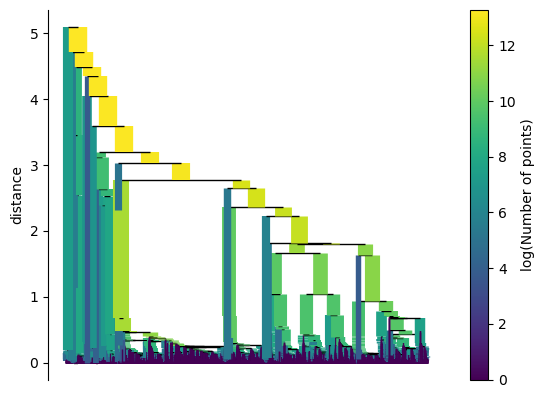

In [57]:
clusterer.single_linkage_tree_.plot()

<AxesSubplot:>

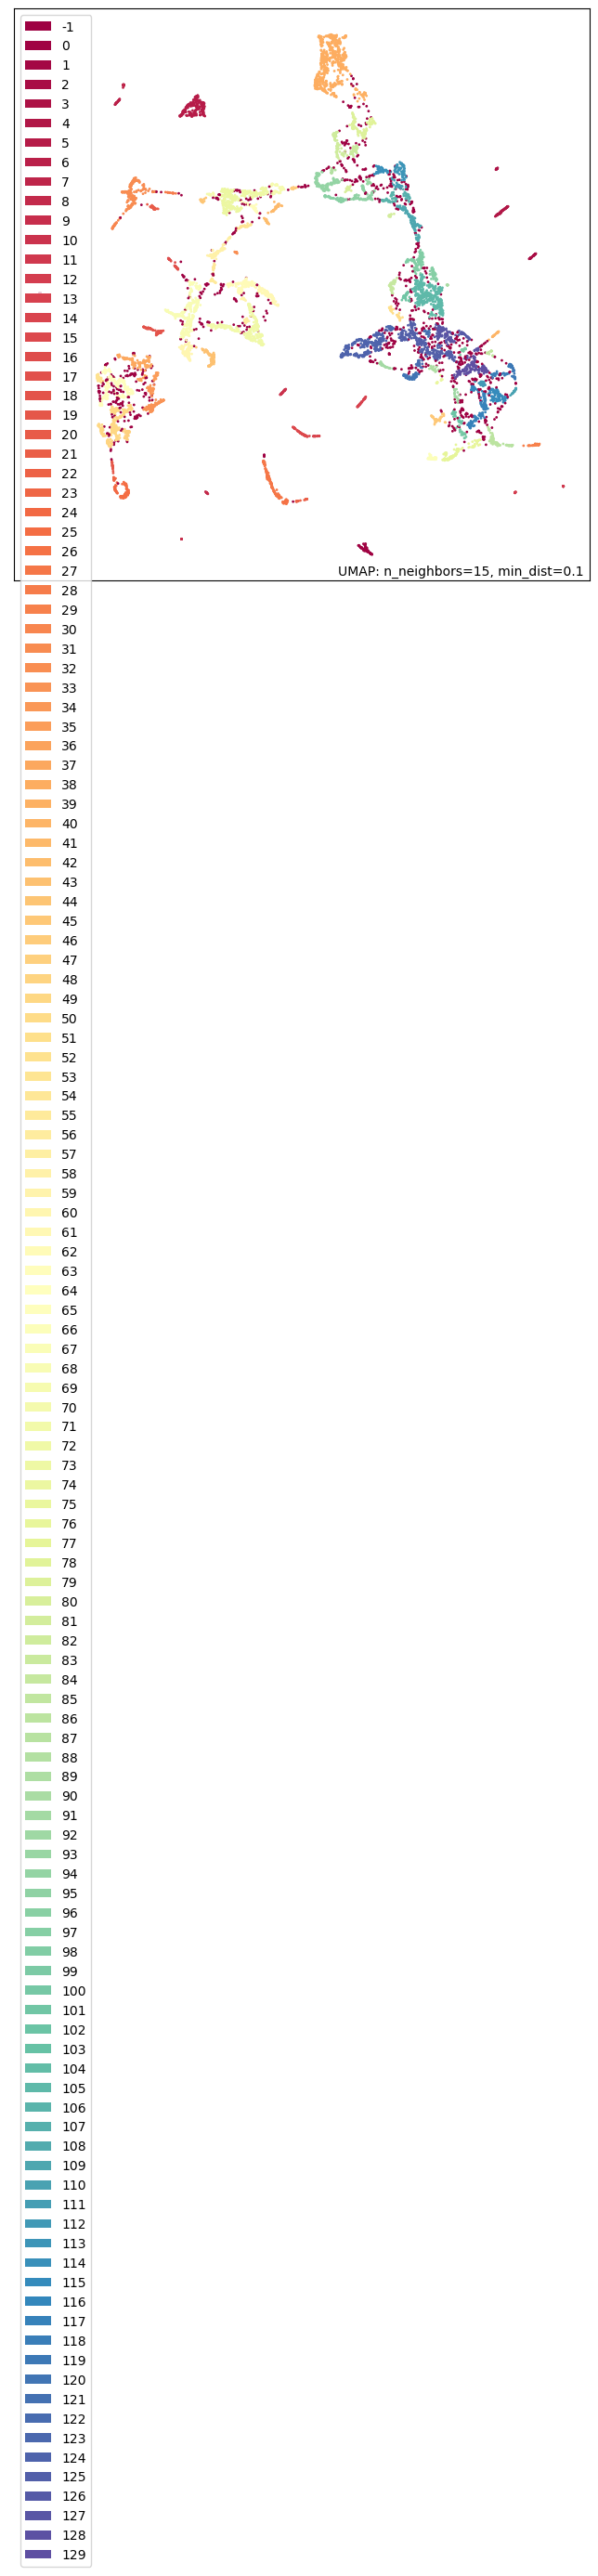

In [44]:
umap.plot.points(mapper, labels=hdbscan_labels)